In [1]:
#Cell 1 - Import the Training Dataset and populate the predictor and response variables
#The response variable is "Result" which is the last field (index = -1)
#The predictors variables are from index 1 to -1 (ignoring last field which is response variable) and
#the first field "key" which is irrelevant for the model. 
import pandas as pd
phish = pd.read_csv('Phising_Training_Dataset.csv')
phish_data = phish.values
X = phish_data[:,1:-1]
y = phish_data[:,-1]

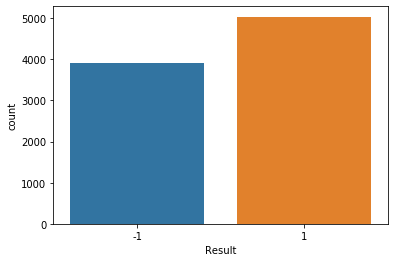

In [2]:
#Cell 2 - Checking whether balanced/imbalanced data
import seaborn as sns
%matplotlib inline
sns.countplot(x='Result',data=phish)
#The difference in number of records with Result = -1 and 1 is 1000. The data looks marginally imbalanced.

In [2]:
#Used stratify parameter to select the records with Result = -1 and 1 in the same proportion as in the parent data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=0)

In [4]:
phish.corr()['Result'][phish.corr()['Result'].abs().argsort()]
#From the result, we see there are many fields which are least correlated with Result.
#Initially, we will go with all the fields and then run feature extraction methods like PCA/FA to run on imp fields

key                           -0.000854
popUpWidnow                   -0.002868
Favicon                       -0.003260
RightClick                     0.004880
Submitting_to_email            0.011981
Iframe                        -0.013429
Redirect                      -0.027197
port                           0.033971
Links_pointing_to_page         0.035003
HTTPS_token                   -0.036573
double_slash_redirecting      -0.037758
on_mouseover                   0.042180
having_At_Symbol               0.050045
URL_Length                     0.059331
Abnormal_URL                  -0.059860
Shortining_Service            -0.066170
Statistical_report             0.068015
DNSRecord                      0.081927
having_IP                      0.094027
Page_Rank                      0.102920
Google_Index                   0.121896
age_of_domain                  0.135198
SFH                            0.217931
Domain_registeration_length   -0.219960
Links_in_tags                  0.238802


In [5]:
#Classification Problem - Popular Models - Logistic Regression, SVM, Decision Trees, Random Forest
#The number of records in dataset is around 9000. The data does not looks enough to train a dense NN model.
#Test for Neural Netwok Classification
#As the Result field is -1 or 1, 
#    Used Loss parameter as hinge
#    Used activation function for output layer as tanh
from keras.models import Sequential
from keras.layers import Dense
#from tensorflow.keras.optimizers import SGD
model = Sequential()
model.add(Dense(12,input_dim=30,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='tanh'))        #o/p -1 or 1
#opt = SGD(learning_rate=0.01)
model.compile(loss='hinge', optimizer='adam', metrics=['accuracy'])  #or squared_hinge because o/p -1 or 1 
#for change in sign
model.fit(X_train, y_train, epochs=10, batch_size=5)
_, accuracy=model.evaluate(X_test,y_test)
accuracy
#Acheived accuracy of 0.525 which is not good enough

Epoch 1/10
1433/1433 [==============================] - 3s 2ms/step - loss: 0.3099 - accuracy: 0.4334
Epoch 2/10
1433/1433 [==============================] - 2s 2ms/step - loss: 0.1629 - accuracy: 0.5237
Epoch 3/10
1433/1433 [==============================] - 2s 2ms/step - loss: 0.1494 - accuracy: 0.5274
Epoch 4/10
1433/1433 [==============================] - 2s 2ms/step - loss: 0.1430 - accuracy: 0.5286: 0s - loss: 0.1439 - accuracy
Epoch 5/10
1433/1433 [==============================] - 2s 2ms/step - loss: 0.1390 - accuracy: 0.5325
Epoch 6/10
1433/1433 [==============================] - 2s 2ms/step - loss: 0.1362 - accuracy: 0.5317
Epoch 7/10
1433/1433 [==============================] - 3s 2ms/step - loss: 0.1324 - accuracy: 0.5320
Epoch 8/10
1433/1433 [==============================] - 2s 2ms/step - loss: 0.1310 - accuracy: 0.5339
Epoch 9/10
1433/1433 [==============================] - 2s 2ms/step - loss: 0.1268 - accuracy: 0.5329: 0s - loss: 0.1279 - accuracy
Epoch 10/10
56/56 [===

0.5259631276130676

In [11]:
#Used Grid Search to select the best model with their hyperparameters
#Used cross validation method with 5 splits to calculate the accuracy 
#We will choose random_state=0 to compare each model on each run
# **** This will take few minutes to run  *****
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model_params = {
    'svm' : {
        'model' : SVC(gamma='auto',random_state=0),
        'params' : {
            'C' : [1, 10, 20],
            'kernel' : ['rbf', 'linear']
        }
    },
    'random_forest' : {
        'model' : RandomForestClassifier(random_state=0),
        'params' : {
            'n_estimators' : [1, 5, 10]
        }
    },
    'logistic_regression' : {
        'model' : LogisticRegression(solver='liblinear',multi_class='auto',random_state=0),
        'params' : {
            'C' : [1, 5, 10]
        }
    }
}

scores = []
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'],mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model' : model_name,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })
pd.DataFrame(scores)

,model,best_score,best_params
0,svm,0.957901,"{'C': 20, 'kernel': 'rbf'}"
1,random_forest,0.960469,{'n_estimators': 10}
2,logistic_regression,0.923618,{'C': 1}


In [7]:
import numpy as np
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
nbModel_grid.best_estimator_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.0s finished


GaussianNB(priors=None, var_smoothing=0.23101297000831597)

In [10]:
from sklearn.metrics import accuracy_score
nbModel = GaussianNB(var_smoothing=1.0)
nbModel.fit(X_train, y_train)
y_pred = nbModel.predict(X_test)
accuracy_score(y_test, y_pred)

0.9134561697375768

In [11]:
#The best model (accuracy score = 0.960469) is Random forest with hyperparameter n_estimators (number of trees) = 10
#Let us see if the accuracy can be improved with Gradient Boosting Algorithm
from sklearn.ensemble import GradientBoostingClassifier
clf = GridSearchCV(GradientBoostingClassifier(random_state=0), {
    'learning_rate' : [0.05, 0.1]
}, cv=5, return_train_score=False)
clf.fit(X, y)
clf.best_score_

0.9410385259631491

In [13]:
#Gradient Boosting Algorithm does not look to improve the score from 0.960469
#Let us concentrate on Random Forest Algo
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
model = RandomForestClassifier(n_estimators=10,random_state=0)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9676158570630933

In [14]:
#We will use a Pipeline to combine the data transform and model into an atomic unit that can be evaluated using the
#cross-validation procedure;
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
for component in range(16,31):
    steps = [('Scaler', StandardScaler()), ('pca', PCA(n_components=component)), 
             ('m', RandomForestClassifier(n_estimators=10))]
    model = Pipeline(steps=steps)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    print('Component: %d (Accuracy: %.3f)' % (component, accuracy_score(y_test, y_pred)))
#In this case, we don’t see any lift in model performance in using the PCA transform.

Component: 16 (Accuracy: 0.955)
Component: 17 (Accuracy: 0.953)
Component: 18 (Accuracy: 0.958)
Component: 19 (Accuracy: 0.958)
Component: 20 (Accuracy: 0.950)
Component: 21 (Accuracy: 0.956)
Component: 22 (Accuracy: 0.956)
Component: 23 (Accuracy: 0.956)
Component: 24 (Accuracy: 0.955)
Component: 25 (Accuracy: 0.958)
Component: 26 (Accuracy: 0.959)
Component: 27 (Accuracy: 0.955)
Component: 28 (Accuracy: 0.959)
Component: 29 (Accuracy: 0.956)
Component: 30 (Accuracy: 0.958)


In [15]:
#We will use a Pipeline to combine the data transform and model into an atomic unit that can be evaluated using the
#cross-validation procedure;
from factor_analyzer import FactorAnalyzer
for component in range(16,31):
    steps = [('Scaler', StandardScaler()), ('fa', FactorAnalyzer(n_factors=component, rotation='varimax')), 
             ('m', RandomForestClassifier(n_estimators=10))]
    model = Pipeline(steps=steps)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    print('Component: %d (Accuracy: %.3f)' % (component, accuracy_score(y_test, y_pred)))
#In this case, we don’t see any lift in model performance in using the PCA transform.

Component: 16 (Accuracy: 0.955)
Component: 17 (Accuracy: 0.959)
Component: 18 (Accuracy: 0.956)
Component: 19 (Accuracy: 0.959)
Component: 20 (Accuracy: 0.961)
Component: 21 (Accuracy: 0.959)
Component: 22 (Accuracy: 0.959)
Component: 23 (Accuracy: 0.966)
Component: 24 (Accuracy: 0.960)
Component: 25 (Accuracy: 0.958)
Component: 26 (Accuracy: 0.963)
Component: 27 (Accuracy: 0.958)
Component: 28 (Accuracy: 0.965)
Component: 29 (Accuracy: 0.964)
Component: 30 (Accuracy: 0.959)


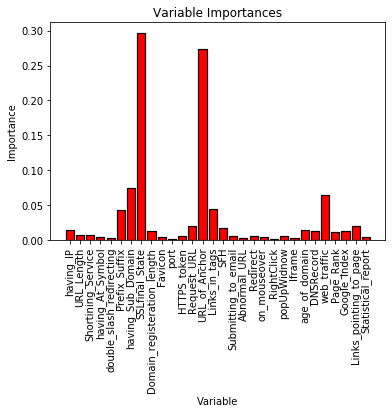

In [4]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10,random_state=0)
model.fit(X_train, y_train)

# Get numerical feature importances
importances = list(model.feature_importances_)
feature_list = list(phish.columns[1:-1])
# List of tuples with variable and importance
feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

import matplotlib.pyplot as plt
%matplotlib inline
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

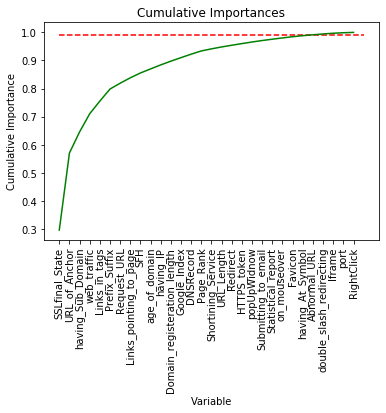

In [5]:
# List of features sorted from most to least important
import numpy as np
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 99% of importance retained
plt.hlines(y = 0.99, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [6]:
# Find number of features which are not at all relevant and contributing to the model
# Add 1 because Python is zero-indexed
print('Number of features for 99% importance:', np.where(cumulative_importances > 0.99)[0][0] + 1)

Number of features for 99% importance: 26


In [9]:
from sklearn.metrics import accuracy_score
for important_feature_count in range(16,31):
    important_feature_names = [feature[0] for feature in feature_importances[0:important_feature_count]]
    # Find the columns of the most important features
    important_indices = [feature_list.index(feature) for feature in important_feature_names]
    # Create training and testing sets with only the important features
    important_train_features = X_train[:, important_indices]
    important_test_features = X_test[:, important_indices]
    model = RandomForestClassifier(n_estimators=10, random_state=0)
    model.fit(important_train_features, y_train)
    y_pred=model.predict(important_test_features)
    print('Feature: %d (Accuracy: %.3f)' % (important_feature_count, accuracy_score(y_test, y_pred)))

Feature: 16 (Accuracy: 0.963)
Feature: 17 (Accuracy: 0.966)
Feature: 18 (Accuracy: 0.964)
Feature: 19 (Accuracy: 0.964)
Feature: 20 (Accuracy: 0.966)
Feature: 21 (Accuracy: 0.962)
Feature: 22 (Accuracy: 0.963)
Feature: 23 (Accuracy: 0.965)
Feature: 24 (Accuracy: 0.969)
Feature: 25 (Accuracy: 0.969)
Feature: 26 (Accuracy: 0.968)
Feature: 27 (Accuracy: 0.968)
Feature: 28 (Accuracy: 0.968)
Feature: 29 (Accuracy: 0.965)
Feature: 30 (Accuracy: 0.967)


In [68]:
#Tune further
# We have excluded tune of below hyperparameters (took long time to run) but not improved the score
#      "min_samples_split" : [2,4,6],
#      "min_samples_leaf" : [1,3,5],
#      "max_features" : ['auto','log2',None],
rfc = RandomForestClassifier(random_state=0)
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]
    
}
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rfc,parameters,cv=5)
important_features = X[:, important_indices]
cv.fit(important_features,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'m

In [69]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
display(cv)

Best parameters are: {'max_depth': 32, 'n_estimators': 250}


0.85 + or -0.003 for the {'max_depth': 2, 'n_estimators': 5}
0.914 + or -0.007 for the {'max_depth': 2, 'n_estimators': 10}
0.897 + or -0.017 for the {'max_depth': 2, 'n_estimators': 50}
0.912 + or -0.015 for the {'max_depth': 2, 'n_estimators': 100}
0.914 + or -0.018 for the {'max_depth': 2, 'n_estimators': 250}
0.907 + or -0.017 for the {'max_depth': 4, 'n_estimators': 5}
0.924 + or -0.006 for the {'max_depth': 4, 'n_estimators': 10}
0.926 + or -0.005 for the {'max_depth': 4, 'n_estimators': 50}
0.926 + or -0.006 for the {'max_depth': 4, 'n_estimators': 100}
0.922 + or -0.008 for the {'max_depth': 4, 'n_estimators': 250}
0.928 + or -0.013 for the {'max_depth': 8, 'n_estimators': 5}
0.934 + or -0.009 for the {'max_depth': 8, 'n_estimators': 10}
0.94 + or -0.007 for the {'max_depth': 8, 'n_estimators': 50}
0.939 + or -0.008 for the {'max_depth': 8, 'n_estimators': 100}
0.94 + or -0.008 for the {'max_depth': 8, 'n_estimators'

In [10]:
#Final Model - 0.964 + or -0.02 for the {'max_depth': 16, 'n_estimators': 250}
#Although random forests usually do not overfit as they are made up of many weak classifiers that are independently
#trained on different subsets of the training data.
#Chosen max depth = 16 as longer depths may overfit the data
important_train_features = X_train[:, important_indices]
important_test_features = X_test[:, important_indices]
model = RandomForestClassifier(n_estimators=250, max_depth = 16, random_state=0)
model.fit(important_train_features, y_train)
y_pred=model.predict(important_test_features)
accuracy_score(y_test, y_pred)

0.9731993299832495

In [21]:
#Check for Overfit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify=y, random_state=0)
important_train_features = X_train[:, important_indices]
important_test_features = X_test[:, important_indices]
model = RandomForestClassifier(n_estimators=250, max_depth = 16, random_state=0)
model.fit(important_train_features, y_train)
y_pred=model.predict(important_test_features)
accuracy_score(y_test, y_pred)

0.9611433675748102

In [23]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
-1,0.964639,0.945946,0.955201,1961.000000
1,0.958513,0.972984,0.965694,2517.000000
accuracy,0.961143,0.961143,0.961143,0.961143
macro avg,0.961576,0.959465,0.960447,4478.000000
weighted avg,0.961195,0.961143,0.961099,4478.000000


In [11]:
phish_test = pd.read_csv('Phising_Testing_Dataset.csv')
phish_data_test = phish_test.values
X_test_data = phish_data_test[:,1:]
important_testing_features = X_test_data[:, important_indices]
Result = model.predict(important_testing_features)
key = phish_data_test[:,0]
sample_submission = pd.DataFrame({'key' : list(key),'Result' : list(Result)})
sample_submission.to_csv('sample_submission.csv', index=False)

In [12]:
s = pd.read_csv('sample_submission.csv')
s.head(5)

,key,Result
0,21338,1
1,21339,-1
2,21340,-1
3,21341,-1
4,21342,1
